In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from IPython.display import clear_output
import time

from numpy.ctypeslib import ndpointer
import ctypes

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import glob

# 입력 데이터
각 데이터는 분단위의 시계열 데이터로 나타난다.  
결측값은 interpolate로 채워 넣었으며, 총 1815958개의 행을 가지고 있다.  

In [2]:
tickers = ['BTC', 'ETH', 'XRP', 'DOGE','ETC']
path = './data/'+tickers[0]+'-M.csv'
df = pd.read_csv(path,parse_dates=[0], index_col=[0])
df.drop('value',axis=1, inplace=True)
df.head(3)

,open,high,low,close,volume
2018-09-19 23:50:00,7180000.0,7187000.0,7180000.0,7187000.0,0.504830
2018-09-19 23:51:00,7186000.0,7188000.0,7181000.0,7181000.0,0.882076
2018-09-19 23:52:00,7184000.0,7188000.0,7183000.0,7188000.0,0.486359
2018-09-19 23:53:00,7188000.0,7188000.0,7188000.0,7188000.0,0.002734
2018-09-19 23:54:00,7188000.0,7188000.0,7187000.0,7187000.0,0.006945


### pred 열
원하는 변동률에 도달하는 기간을 나타낸다.  
상승의 경우 양수로, 하강의 경우 음수로 나타내며, 각 절대값은 도달하는 기간이다.  
예) per(df, 0.05) 에서 2490의 경우 2490분 후에 5%만큼 상승한다는 것을 나타낸다.  

Python의 경우 속도가 느려 C언어를 이용한 동적 라이브러리를 사용하였다. 

In [3]:
from pymodule.dllMod import pred_per
pred = pred_per(df, 0.05)

# Custom DataSet 생성  
dataloader로 변환  

### 전처리
각 항목들을 직전에 대한 변동률을 %로 나타내었으며  
예측값을 포함한 전부 절대값 최대의 나눗셈으로 정규화를 하였다. 

해당 정규화를 통해 예측값이 -1에 가까울수록 하향추세, 1에 가까울수록 상승추세를 나타낸다. 

In [4]:
from pymodule.dataMod import OHLCDataset
dataset = OHLCDataset(df[10:-4], pred[10:-4], 50)

해당 데이터를 분 데이터, 10분 데이터, 1시간 데이터, 일 데이터로 정규화하였으며,  
모델의 입력 데이터는 4차원으로 쌓아서 나타낸다. 

In [5]:
from torch.utils.data import DataLoader, random_split

test_size = 262144
train_set, test_set = random_split(dataset,[len(dataset)-test_size, test_size])
print(f'train dataset length : {len(train_set)}')
print(f'test dataset length : {len(test_set)}')

train_dataloader = DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_set, batch_size=128, shuffle=True, drop_last=True)

train dataset length : 1552374
test dataset length : 262144


In [6]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([256, 4, 50, 5])
Labels batch shape: torch.Size([256, 1])


# 모델 설계

각각의 범위를 가진 시계열 데이터를 LSTM을 이용하여 추세를 확인한다.  
각 시계열 데이터의 추세들을 모아 하나의 결과를 나타낸다. 

In [7]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

cuda:0 is available


In [17]:
import pymodule.models import sCNN

seq_length = 50
model = sCNN(hidden_size = 10, num_layers = 3, seq_length = seq_length).to(device)

# 모델 최적화

In [11]:
optimizer = optim.SGD(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

In [12]:
from pymodule.models import fit

path = "./sCNN.pt"
# model = torch.load(path).to(device)
losses = []
val_losses = []
start = time.time()
for epoch in range(20):
    epoch_loss = fit(epoch,model,train_dataloader, criterion, optimizer, phase = 'train')
    losses.append(epoch_loss)
    val_epoch_loss = fit(epoch, model, test_dataloader, criterion, optimizer, phase ='valid')
    val_losses.append(val_epoch_loss)
    torch.save(model,path)
    print((time.time()-start)/60)

epoch:0, trainloss is 0.00012006025723943182
epoch:0, validloss is 7.703703824635255e-05
5.948517902692159
epoch:1, trainloss is 0.00011997558805806684
epoch:1, validloss is 7.703707806605564e-05
11.952514938513438
epoch:2, trainloss is 0.00011999635770293487
epoch:2, validloss is 7.703688516791374e-05
17.84411722024282
epoch:3, trainloss is 0.00011986127009102735
epoch:3, validloss is 7.703705541395323e-05
23.794461898008983
epoch:4, trainloss is 0.00011996444624214808
epoch:4, validloss is 7.703687224847044e-05
29.79577539364497
epoch:5, trainloss is 0.00011991306676138117
epoch:5, validloss is 7.703679787685047e-05
35.750282442569734
epoch:6, trainloss is 0.00012003200584137509
epoch:6, validloss is 7.703668710679068e-05
41.52036516269048
epoch:7, trainloss is 0.00011995856967015822
epoch:7, validloss is 7.703674379211378e-05
47.24270743926366
epoch:8, trainloss is 0.00012003159726174682
epoch:8, validloss is 7.70366324456262e-05
53.362304985523224
epoch:9, trainloss is 0.0001199386

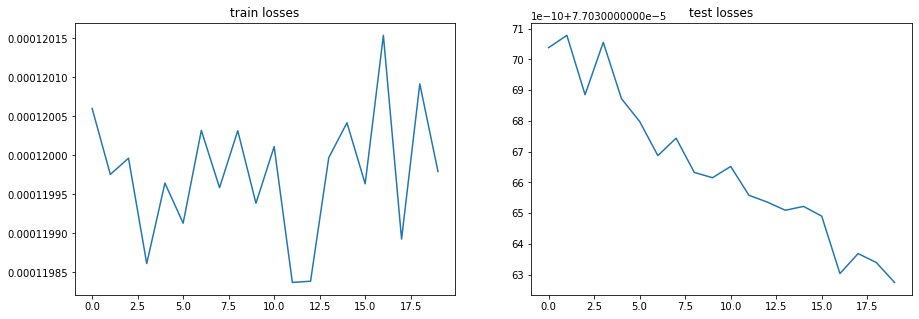

In [13]:
f,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(losses)
ax[0].set_title('train losses')

ax[1].plot(val_losses)
ax[1].set_title('test losses')
plt.show()